<a href="https://colab.research.google.com/github/yurou66/TabPFN/blob/main/TabPFN_Demo_V1_Local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to the hands-on Colab notebook for TabPFN!
This code shows how to locally (with GPU support) install and run TabPFN. For fast inference with additional features use **[TabPFN client](https://tinyurl.com/tabpfn-colab-online)**.

**Installation**
* First, copy the notebook to be able to modify it.
* Then, run the cells in the installation block, this should
be good enough!

---

> 🔵 **Hint** <br>
We recommend first enabling the **Table of Contents** with the `☰` icon in the top left and collapsing all sections by selecting all cells `Ctrl + Shift + A` and then pressing `Ctrl + ]`.

---

Thank you to [Lennart Purucker](https://github.com/LennartPurucker) for providing the original version of this notebook!

# Installation

Restart your runtime and rerun the *cell*, if Colab asks for it.

In [1]:
# Install sklearn
!pip install scikit-learn==1.5.2

# Install TabPFN
!pip install tabpfn

# TabPFN Community installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[all]

# Install Baselines
!pip install catboost xgboost

# Install example datasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

**Now Restart the Runtime**

# Necessary Imports for the Notebook

The examples in this notebook require the following imports.
Make sure to run this cell before any other cell.




### In order to get the fastest predictions you need to enable GPUs for the notebook:
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

In [2]:
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Predicting with TabPFN

For our first example, we will use the client to predict on [toy data from scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

## Classification

We now compare the classification performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure classification performance using [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). These toy datasets are simple to solve, so the ROC AUC will be very high.

In [ ]:
# Parkinson's Disease dataset: Predict Parkinson's disease presence
# Features: Voice measurements (e.g., frequency, amplitude)
# Samples: 195 cases
df = fetch_openml('parkinsons')

# Alternative datasets (commented for reference):

# German Credit Fraud (ID: 31)
# Samples: 1,000
# Features: 20 (account info, credit history, employment)
# Target: Good/Bad credit risk
# df = fetch_openml(data_id=31)

# Cholesterol dataset: Predict cholesterol levels
# Features: Patient characteristics, medical measurements
# Samples: 303 patients
# Target: Cholesterol levels in mg/dl
# df = fetch_openml('cholesterol', version=2, as_frame=True)

# Primary Tumor dataset: Predict tumor type and size
# Features: Patient symptoms, medical test results
# Samples: 339 patients
# Target: Tumor classification and size
# df = fetch_openml('primary-tumor', version=1, as_frame=True) - too many classes!

# Heart Disease dataset (Statlog): Predict presence of heart disease
# Features: Clinical and test measurements
# Samples: 270 patients
# Target: Binary heart disease diagnosis
# df = fetch_openml("heart-statlog", version=1)

# Diabetes dataset: Predict diabetes presence
# Features: Medical measurements, patient history
# Samples: 768 patients
# Target: Binary diabetes diagnosis
#df = fetch_openml("diabetes", version=1)

# Hypothyroid dataset: Predict thyroid condition
# Features: Blood test results, patient symptoms
# Samples: 3772 patients
# Target: Thyroid condition classification
# df = fetch_openml('hypothyroid')

X, y = df.data, df.target

# Encode target labels to classes
le = LabelEncoder()
y = le.fit_transform(y)

# Convert all categorical columns to numeric
for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print dataset description
display(Markdown(df['DESCR']))

display(X)

**Author**:   
**Source**: UCI
**Please cite**: 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. BioMedical Engineering OnLine 2007, 6:23 (26 June 2007) 

* Abstract: 

Oxford Parkinson's Disease Detection Dataset

* Source:

The dataset was created by Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech, Denver, Colorado, who recorded the speech signals. The original study published the feature extraction methods for general voice disorders.

* Data Set Information:
This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. 

Further details are contained in the following reference -- if you use this dataset, please cite: 
Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).


* Attribute Information:

Matrix column entries (attributes): 
name - ASCII subject name and recording number 
MDVP:Fo(Hz) - Average vocal fundamental frequency 
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency 
MDVP:Flo(Hz) - Minimum vocal fundamental frequency 
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency 
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude 
NHR,HNR - Two measures of ratio of noise to tonal components in the voice 
status - Health status of the subject (one) - Parkinson's, (zero) - healthy 
RPDE,D2 - Two nonlinear dynamical complexity measures 
DFA - Signal fractal scaling exponent 
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

Downloaded from openml.org.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train and evaluate TabPFN
y_pred = TabPFNClassifier(random_state=42).fit(X_train, y_train).predict_proba(X_test)

# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1])
print(f"TabPFN ROC AUC: {score:.4f}")

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN ROC AUC: 0.9862


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

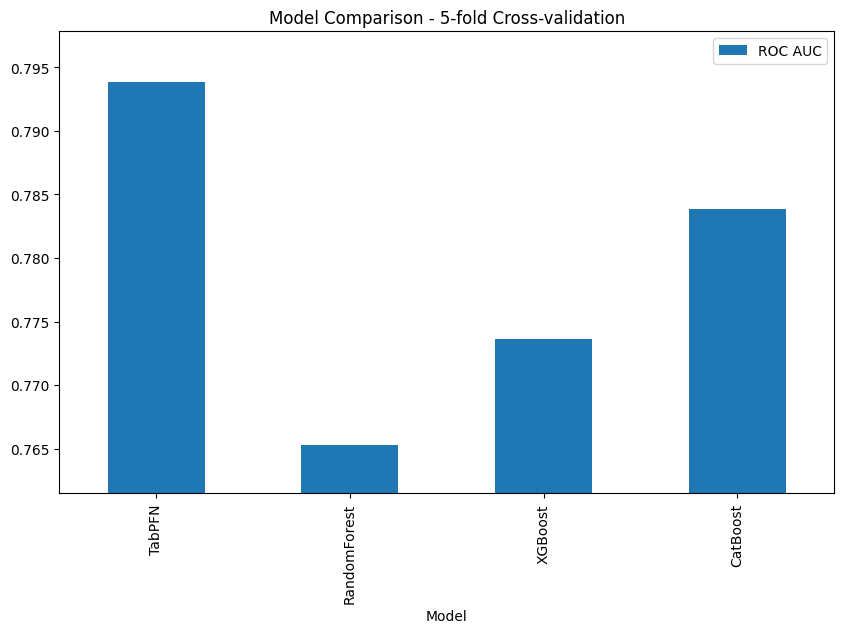

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /content/tabpfn-extensions/src/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-od3j1g5m.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /content/tabpfn-extensions/src/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-llderlii.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier-llderlii.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [-0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273, -0.9460227272727273]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [-0.94602273 -0.94318182 -0.94034091]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [1. 0. 0.]
INFO:t

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

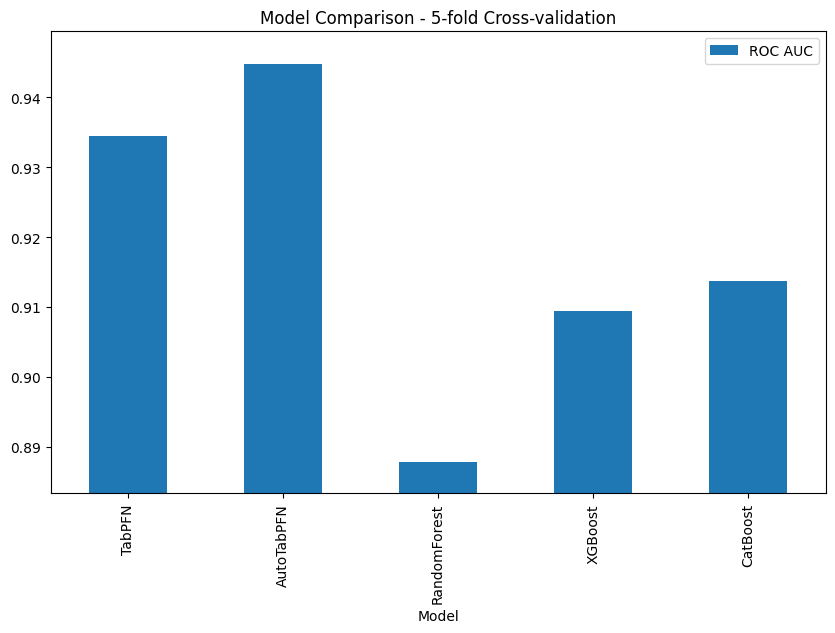

In [ ]:
# Adding AutoTabPFN which is significantly slower but gives best results

# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('AutoTabPFN', AutoTabPFNClassifier(max_time=30, device="cuda")), # takes 30 seconds to run so excluded previously
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X, y, cv=3, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

## Regression

We now compare the regression performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure regression performance using [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html).

In [ ]:
# Boston Housing dataset
# Regression task: Predict house prices
# Features: Neighborhood characteristics, housing attributes
# Samples: 506 neighborhoods
# Target: Median house value in $1000s
df = fetch_openml(data_id=531, as_frame=True)

# Alternative datasets (commented for reference):

# Liver Disorders dataset
# Classification task: Predict liver disorder presence
# Features: Blood test results, alcohol consumption
# Samples: 345 patients
# Target: Binary liver disorder diagnosis
# df = fetch_openml("liver-disorders", version=1)

# Grid Stability dataset
# Regression task: Predict electrical grid stability
# Features: Power system measurements, grid parameters
# Samples: 10,000 simulations
# Target: Grid stability score
#df = fetch_openml(data_id=44973, as_frame=True)

# Concrete Compressive Strength dataset
# Regression task: Predict concrete strength
# Features: Concrete components (cement, water, aggregates)
# Samples: 1,030 concrete samples
# Target: Compressive strength in MPa
#df = fetch_openml(data_id=44959, as_frame=True)

X, y = df.data, df.target

# Convert all 'object' and 'category' columns to numeric
for col in X.select_dtypes(['object', 'category']).columns:
    X[col] = pd.factorize(X[col])[0]  # Factorize encodes as integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print dataset description
display(Markdown(df['DESCR']))

display(X)

<ipython-input-6-7ea6a9e5e0fa>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.factorize(X[col])[0]  # Factorize encodes as integers


**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's


Information about the dataset
CLASSTYPE: numeric
CLASSINDEX: last

Downloaded from openml.org.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,1,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,1,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,2,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,2,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,0,273.0,21.0,393.45,6.48


In [ ]:
# Train and evaluate TabPFN
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Calculate Variance Explained (R2 Score)
score = root_mean_squared_error(y_test, y_pred)
print(f"TabPFN RMSE: {score:.4f}")

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:100: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN RMSE: 2.6105


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (Root Mean Squared Error - Smaller is better)')

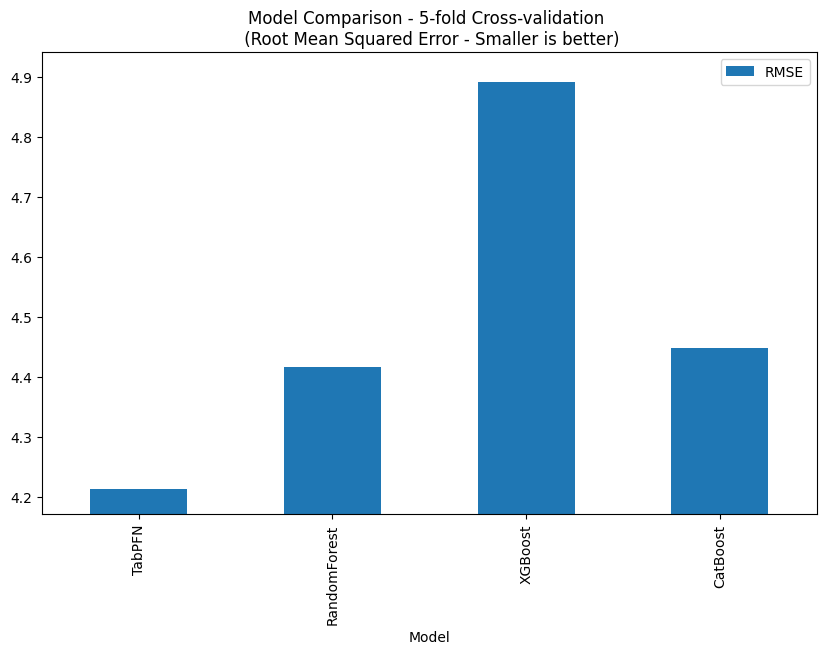

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ('TabPFN', TabPFNRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'neg_root_mean_squared_error'
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=-1).mean()
          for name, model in models}


# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'RMSE'])
df.RMSE = -df.RMSE # Smaller is better
ax = df.plot(x='Model', y='RMSE', kind='bar', figsize=(10, 6))
ax.set_ylim(df['RMSE'].min() * 0.99, df['RMSE'].max() * 1.01)
ax.set_title('Model Comparison - 5-fold Cross-validation \n (Root Mean Squared Error - Smaller is better)')

## Data Generation / Outlier Detection

100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


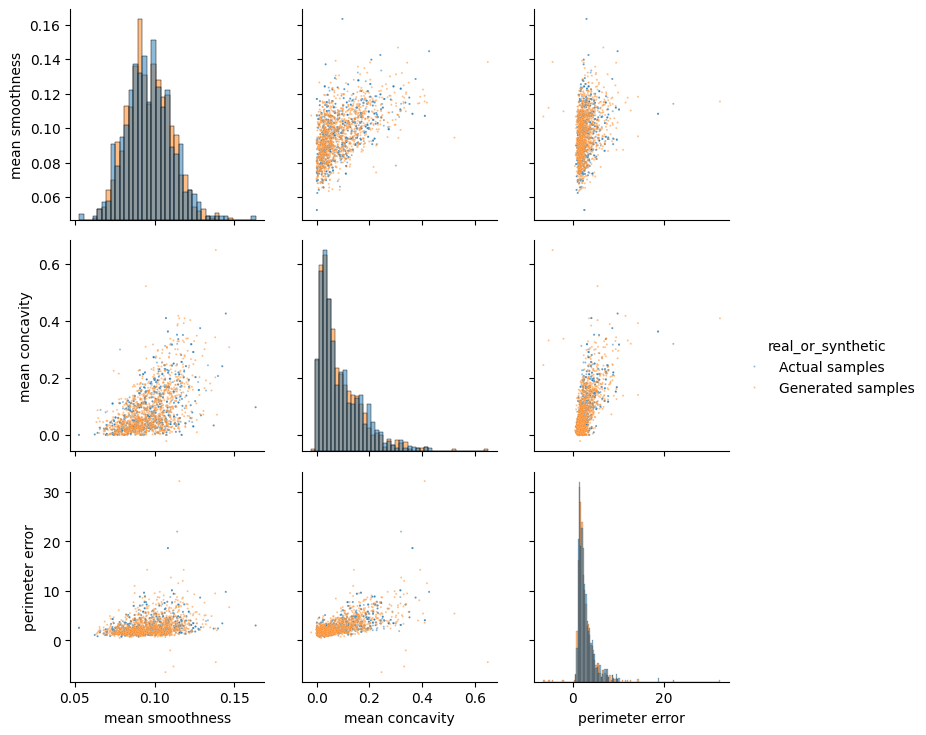

In [ ]:
from tabpfn_extensions import unsupervised

# Load and prepare breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df['data'], df['target']
feature_names = df['feature_names']

# Initialize TabPFN models
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=TabPFNClassifier(),
    tabpfn_reg=TabPFNRegressor()
)

# Select features for synthetic data generation
# Example features: [mean texture, mean area, mean concavity]
feature_indices = [4, 6, 12]

# Run synthetic data generation experiment
experiment = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type='unsupervised'
)

results = experiment.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=feature_names,
    temp=1.0,  # Temperature parameter for sampling
    n_samples=X.shape[0] * 2,  # Generate twice as many samples as original data
    indices=feature_indices
)

## Outlier detection

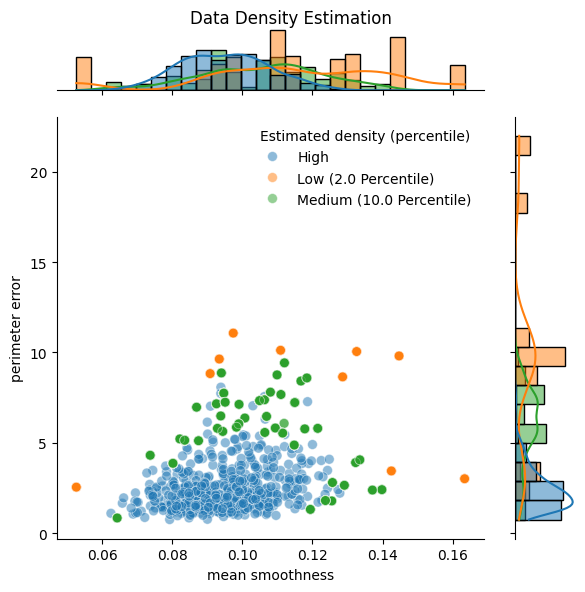

In [ ]:
import torch
from sklearn.datasets import load_breast_cancer
from tabpfn_extensions import unsupervised
from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor

# Load data
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
attribute_names = df["feature_names"]

# Initialize models
clf = TabPFNClassifier(n_estimators=4)
reg = TabPFNRegressor(n_estimators=4)
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf, tabpfn_reg=reg
)

# Run outlier detection
exp_outlier = unsupervised.experiments.OutlierDetectionUnsupervisedExperiment(
    task_type="unsupervised"
)
results = exp_outlier.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=attribute_names,
    indices=[4, 12],  # Analyze features 4 and 12
)

## Interpretability

PermutationExplainer explainer: 51it [01:37,  2.07s/it]


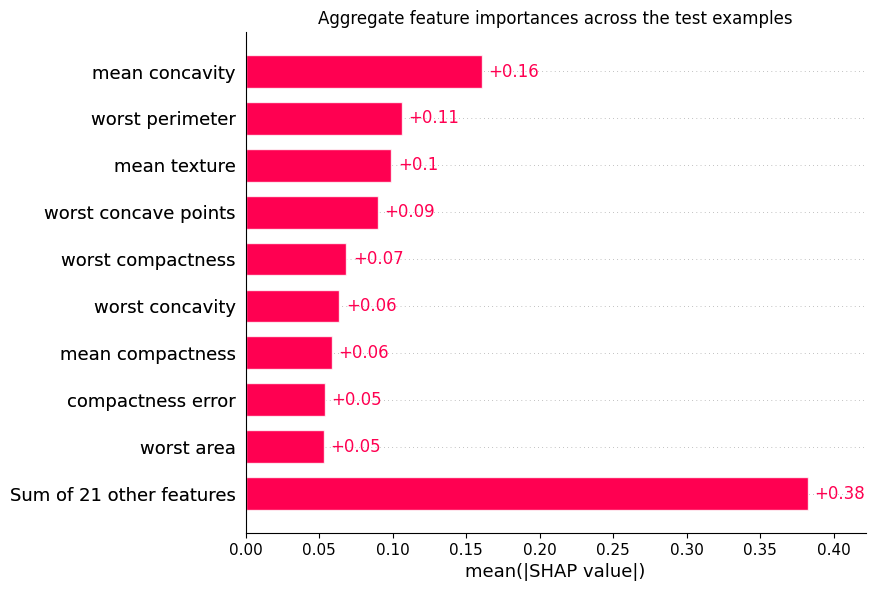

/content/tabpfn-extensions/src/tabpfn_extensions/interpretability/shap.py:134: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


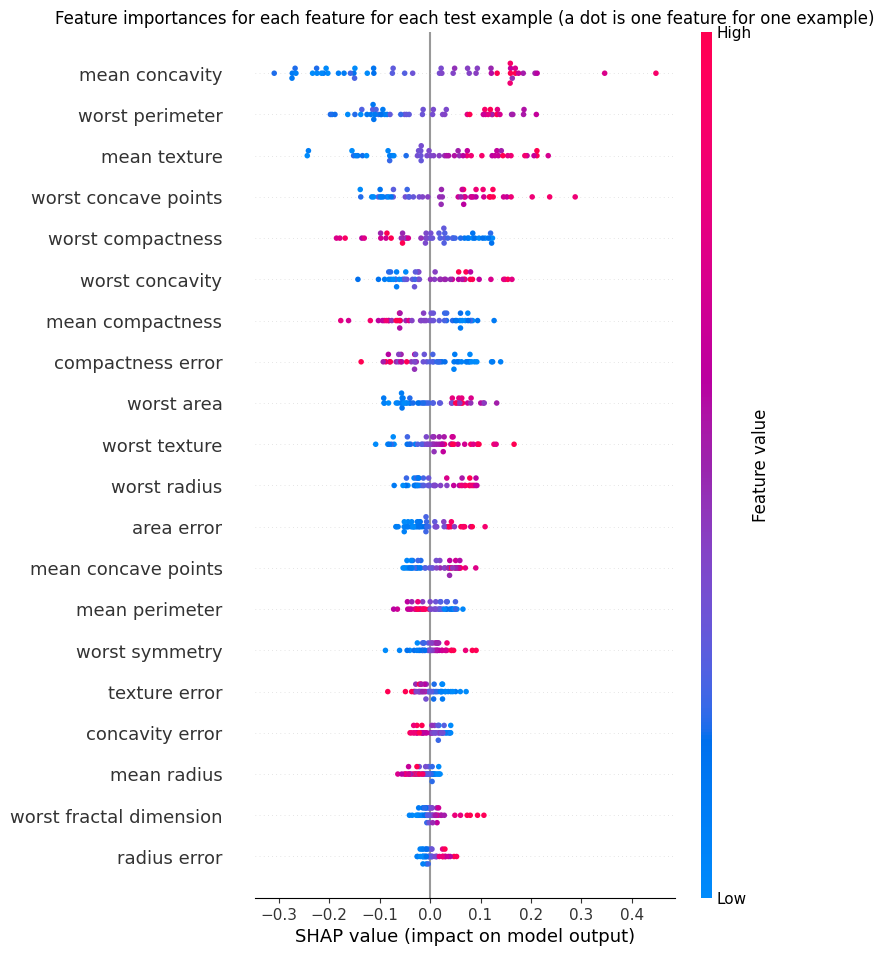

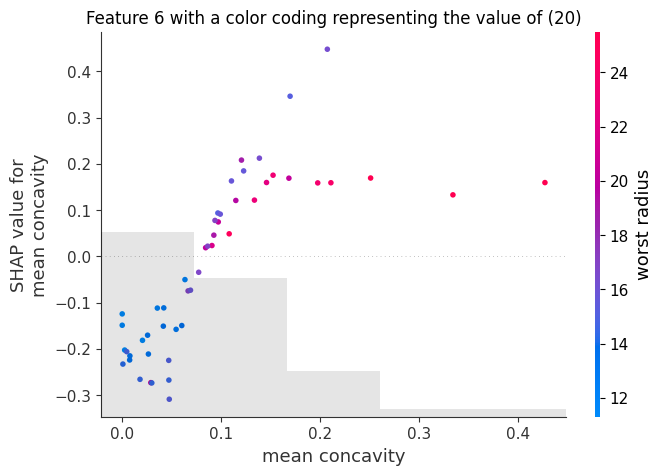

In [ ]:
from tabpfn_extensions import interpretability

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5
)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)


## Feature selection

In [ ]:
from tabpfn_extensions import interpretability

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
clf = TabPFNClassifier(n_estimators=1)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf,
    X=X,
    y=y,
    n_features_to_select=2,
    feature_names=feature_names
)

# Print selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")


Selected features:
- worst perimeter
- worst smoothness


# Predictive Behavior of TabPFN

In this section, we explore the behavior of predictions from TabPFN on various toy functions.

## Decision Boundary during Classification

First, let us inspect the decision boundary for different classifiers.
The decision bounds show how smoothly a model learns to transition between classes and how well it fits the data.

In the first cell, we create the data and code to plot the decision boundary. The second cell then generates the plot.

In [ ]:
# Toy functions that generate the data
def generate_circle(n_datapoints, radius, noise_factor):
    angles = np.linspace(0, 2*np.pi, n_datapoints).T
    x = radius * np.cos(angles) + np.random.randn(n_datapoints) * noise_factor
    y = radius * np.sin(angles) + np.random.randn(n_datapoints) * noise_factor

    return np.stack([x, y]).T

def generate_concentric_cirlces(radii, num_points_per_circle, noise_factor=1/15):
    circles = []
    for r, num_points in zip(radii, num_points_per_circle):
        circles.append(generate_circle(num_points, r, noise_factor))

    circle = np.vstack(circles)
    return circle

def generate_circle_data(num_points_per_circle, radii, noise_factor):
    radii = np.array(radii)
    circles_1 = generate_concentric_cirlces(radii, num_points_per_circle, noise_factor)
    circles_1 = np.hstack([circles_1, np.zeros((sum(num_points_per_circle) , 1))])

    circles_2 = generate_concentric_cirlces(radii + 0.3, num_points_per_circle, noise_factor)
    circles_2 = np.hstack([circles_2, np.ones((sum(num_points_per_circle), 1))])

    circles = np.vstack([circles_1, circles_2])
    X, y = circles[:, :2], circles[:, 2]
    return X, y

# Generate the data
X_train, y_train = generate_circle_data(
  num_points_per_circle=[50, 100, 200],
  radii=[1,2,4],
  noise_factor=0.1
)

# Function for plotting
def plot_decision_boundary(ax, model, model_name):
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(model_name)
    DecisionBoundaryDisplay.from_estimator(
        model, X_train[:, :2], alpha=0.6, ax=ax, eps=0.2, grid_resolution=50, response_method="predict_proba", cmap=plt.cm.RdBu,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

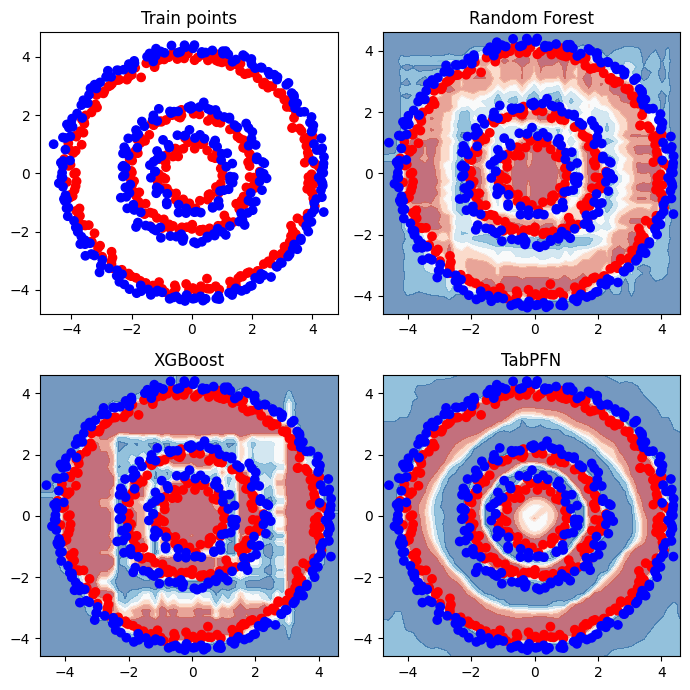

In [ ]:
rf = RandomForestClassifier().fit(X_train[:, :2], y_train)
xgb = XGBClassifier().fit(X_train[:, :2], y_train)
tabpfn = TabPFNClassifier().fit(X_train[:, :2], y_train)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7,7))

# Plot Train Points
ax_points = axes[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"]))

# Plot Random Forest
ax_rf = axes[0, 1]
plot_decision_boundary(ax_rf, rf, "Random Forest")

# Plot XGBoost
ax_xgb = axes[1, 0]
plot_decision_boundary(ax_xgb, xgb, "XGBoost")

# Plot TabPFN
ax_tabpfn = axes[1, 1]
plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Sin Curve Fitting with Regression

Next, we investigate the curve-fitting behavior of the different models on a sin curve.

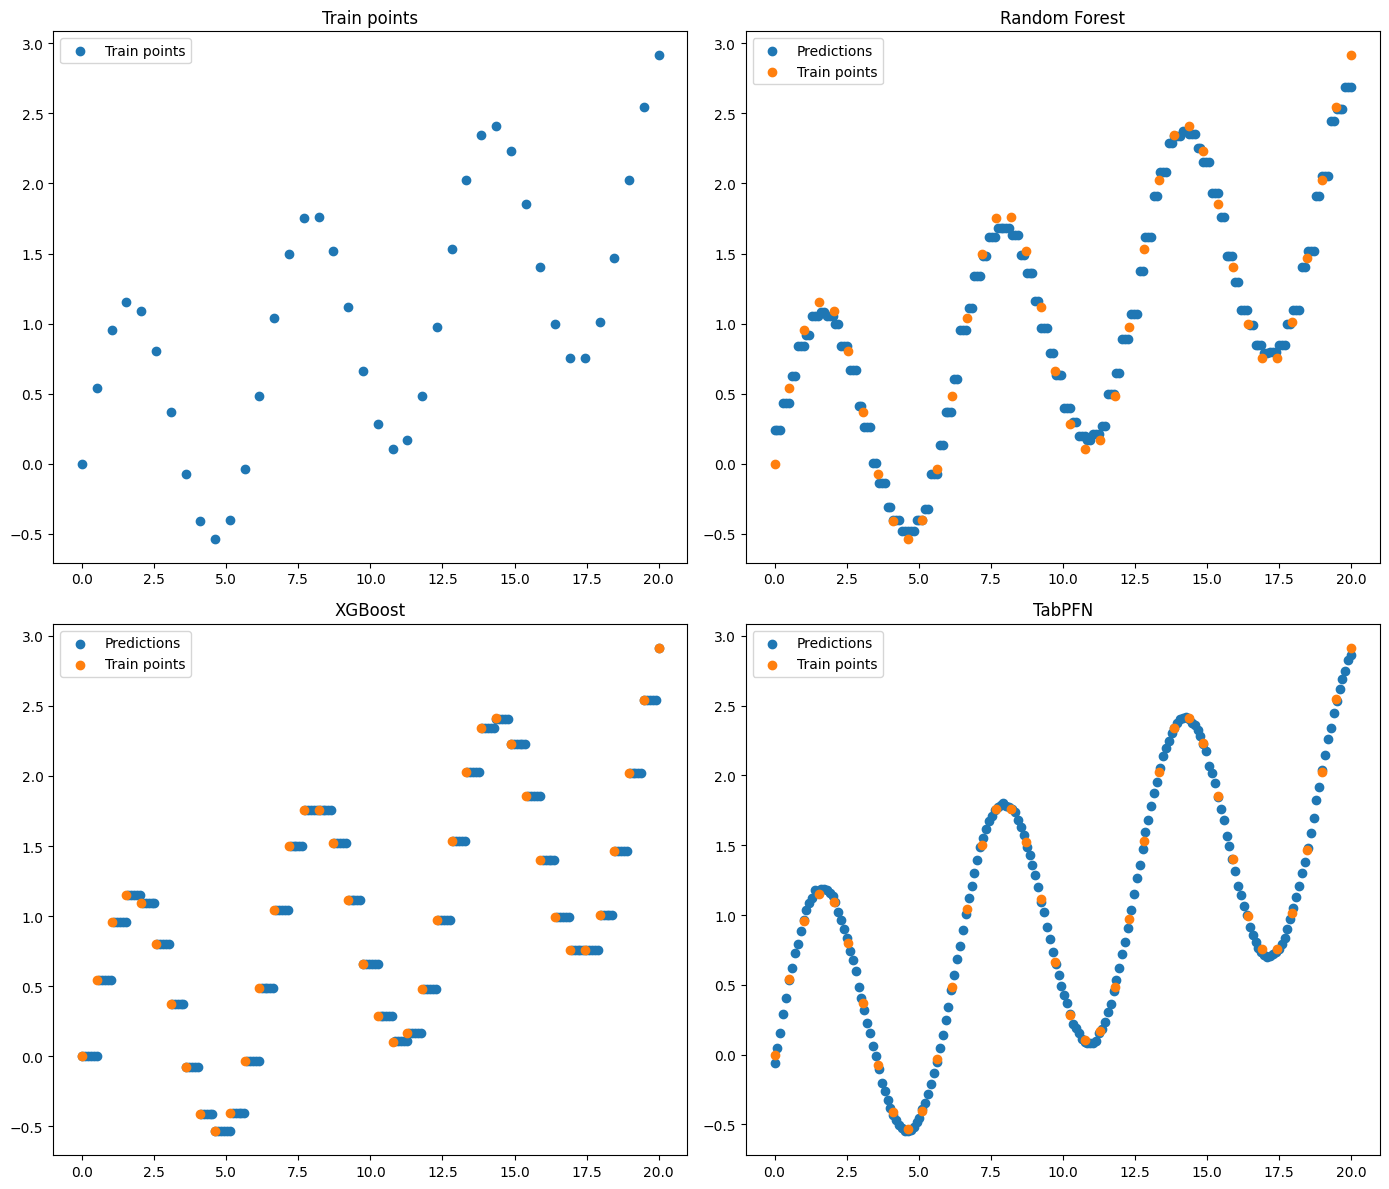

In [ ]:
# Toy function to generate data
def generate_sinx_plus_x(N):
    x = np.linspace(0, 20, N)
    y = np.sin(x) + x/10

    return x.reshape(-1, 1), y

# Utility function for plotting
def plot_predictions(ax, model, model_name):
    X_test = np.linspace(0, 20, 200).reshape(-1, 1) # Predict for 200 points  between 0 and 20
    y_preds = model.predict(X_test)
    ax.set_title(model_name)
    ax.scatter(X_test, y_preds, label="Predictions")
    ax.scatter(X_train, y_train, label="Train points")
    ax.legend()

# Generate data
X_train, y_train = generate_sinx_plus_x(N=40)

# Fit Models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot train points
ax_points = axs[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train, y_train, label="Train points")
ax_points.legend()

# Plot predictions for Random Forest
ax_rf = axs[0, 1]
plot_predictions(ax_rf, rf, "Random Forest")

# Plot predictions for XGBoost
ax_xgb = axs[1, 0]
plot_predictions(ax_xgb, xgb, "XGBoost")

# Plot predictions for TabPFN
ax_tabpfn = axs[1, 1]
plot_predictions(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN for a toy function with noise.

In [ ]:
### Code to generate the plot (feel free to ignore)
def plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, full_preds, color_multiplier=5):
  all_quantiles = preds[f"quantiles"]
  y = np.array(all_quantiles) # shape of y: (9, number of samples)

  # Calculate the maximum and minimum values in y
  y_max = np.max(y, axis=0)
  y_min = np.min(y, axis=0)

  # Calculate the widths of each quantile bin
  quantile_bin_widths = np.diff(y, axis=0) # shape of quantile_bin_widths: (8, number of samples)

  # Normalize the bin widths for a given x
  per_x_normalized_bin_widths = (quantile_bin_widths) / (y_max - y_min)

  # Plotting
  num_bins, num_data_points = per_x_normalized_bin_widths.shape[0], per_x_normalized_bin_widths.shape[1]
  rect_width = (x_test[1] - x_test[0]).squeeze() # assuming the x query points are equally spaced out

  for i in range(num_data_points):
      for j in range(num_bins):
          rect_height = quantile_bin_widths[j, i]
          rect = plt.Rectangle(
                    xy=(x_test[i][0] - rect_width / 2, y[j, i]),
                    width=rect_width,
                    height=quantile_bin_widths[j, i],
                    facecolor=plt.cm.viridis(per_x_normalized_bin_widths[j, i] * color_multiplier),
                    edgecolor='none'
                )
          ax.add_patch(rect)

  # Set limits and labels
  ax.plot(x, y_line, label='True line', color='blue')
  ax.set_xlim(min(x_test) - 1, max(x_test) + 1)
  ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  # ax.plot(x, y, label='True line', color='blue')
  ax.scatter(x, y_noisy, label='Noisy data', color='red', s=10)

  plt.title('TabPFN Regression Uncertainty')
  plt.show()

# Generate Data
def generate_line_with_heteroscedastic_noise(m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1):
    x = np.linspace(x_start, x_end, num_points)
    noise = np.random.randn(num_points)
    y = m * x
    y_noisy = y + (noise * noise_factor * x)

    return x.reshape(-1, 1), y, y_noisy

def generate_line_with_heteroscedastic_noise_with_gap(m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1):
    extra_points = num_points // 3
    x, y, y_noisy = generate_line_with_heteroscedastic_noise(m, num_points+extra_points, x_start, x_end, noise_factor)
    a = np.arange(num_points + extra_points)
    idx = np.where((a < num_points/3) | (a > num_points/3 + extra_points))
    return x[idx], y[idx], y_noisy[idx]

x, y_line, y_noisy = generate_line_with_heteroscedastic_noise_with_gap(0.8)
x_test = np.linspace(0, 100, 200).reshape(-1, 1)

In [ ]:
reg = TabPFNRegressor()
reg.fit(x, y_noisy)
preds = reg.predict(x_test, output_type="full")

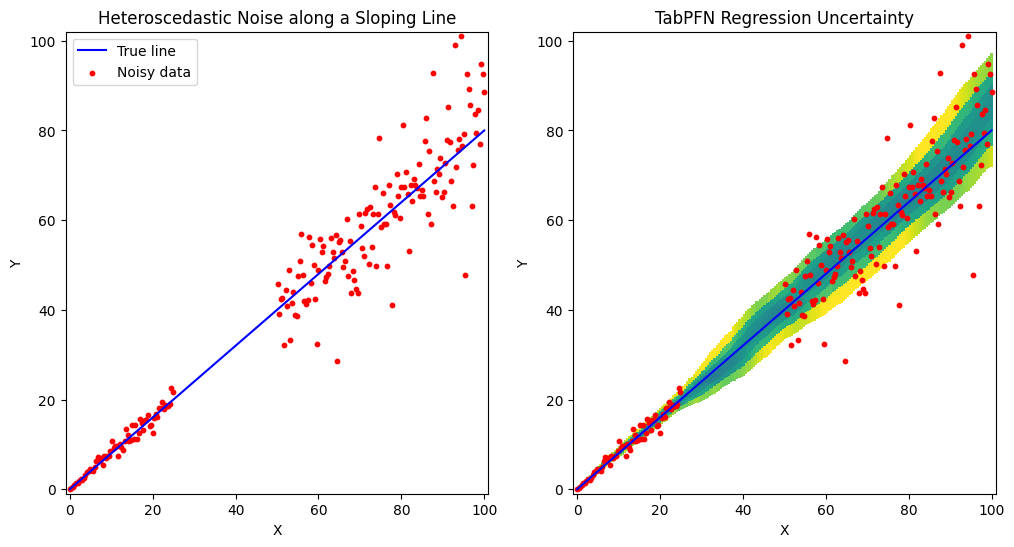

In [ ]:
fig = plt.figure(figsize=(12,6))

# Plot the original data
ax = fig.add_subplot(121)
ax.plot(x, y_line, label='True line', color='blue')
ax.scatter(x, y_noisy, label='Noisy data', color='red', s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(min(x) - 1, max(x) + 1)
ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
ax.set_title('Heteroscedastic Noise along a Sloping Line')
ax.legend()

# plot the uncertainty estimates obtained from TabPFN
ax = fig.add_subplot(122)
plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, preds, color_multiplier=5)

## BATMAN

Na na na na

na na na na

na na na na na

Batman

In [ ]:
# "Just run this, no questions" - Batman
!wget -nc https://github.com/PriorLabs/TabPFNDemoFiles/raw/main/thebat.npy # download a file we need

def sample_random_points(n, array, seed):
    np.random.seed(seed)
    x, y = np.random.randint(0, array.shape[1], (n,)), np.random.randint(0, array.shape[0], (n,))
    return np.vstack((x, y)).T, array[y, x].reshape(-1, 1).flatten()

def plot_for_all_models(n_train_points, data_source="thebat.npy", random_state=9001):
    # Load the data
    data_array = np.load(data_source)
    X_train, y_train = sample_random_points(n_train_points, data_array, random_state)

    # Fit models
    xgb = XGBClassifier(random_state=42).fit(X_train, y_train)
    catboost = CatBoostClassifier(random_state=42, verbose=0).fit(X_train, y_train)
    tabpfn = TabPFNClassifier()
    tabpfn.fit(X_train, y_train)

    ####### PLOTTING  #######
    cmap = ListedColormap(["black", "yellow"])
    def plot_decision_boundary(ax, model, model_name):
        ax.set_title(model_name)
        ax.set_aspect("equal")
        DecisionBoundaryDisplay.from_estimator(
            model, X_train, alpha=0.8, ax=ax, eps=0.2, grid_resolution=50, response_method="predict_proba", cmap=cmap
        )
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

    fig = plt.figure(figsize=(32,8))

    ### Plot Train Points ###
    ax_points = fig.add_subplot(141)
    ax_points.set_title(f"Train points ({n_train_points})")
    ax_points.set_aspect("equal")
    ax_points.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)

    ### Plot XGBoost ###
    ax_xgb = fig.add_subplot(142)
    plot_decision_boundary(ax_xgb, xgb, "XGBoost")

    ### Plot Random Forest ###
    ax_catboost = fig.add_subplot(143)
    plot_decision_boundary(ax_catboost, catboost, "CatBoost")

    ### Plot TabPFN ###
    ax_tabpfn = fig.add_subplot(144)
    plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

plot_for_all_models(n_train_points=2500, data_source="thebat.npy", random_state=9001)

File ‘thebat.npy’ already there; not retrieving.

